In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import  Point
import os
from pathlib import Path
import json
import random
import rasterio




In [8]:
from rural_beauty.config import UK_scenic_raster, NUTS_UK, CLC_coverage_EU_dir

In [9]:
NUTS_path = NUTS_UK

from rural_beauty.config import BFN_features_diverse, BFN_features_unique, BFN_features_beauty

features = {**BFN_features_diverse, **BFN_features_unique, **BFN_features_beauty}



In [10]:
# optionally include every CLC layer. 
for file in os.listdir(CLC_coverage_EU_dir):
    if file.endswith(".tif"):
        temp_path = Path(CLC_coverage_EU_dir / file)
        temp_name = temp_path.stem[5:] + "_1"
        
        # check if it is already in the features dict
        if temp_name in features.keys():
            continue
        else:
            features[temp_name] = temp_path
        

In [11]:
import os
some_missing = False
for label, path in features.items():
    if os.path.exists(path):
        pass
    else:
        some_missing = True
        print(f"{path} is missing")

if not some_missing:
    print("All files exist")

All files exist


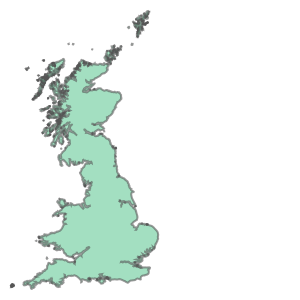

In [12]:
NUTS = gpd.read_file(NUTS_path)
polygon = NUTS.geometry.iloc[0]
polygon


In [13]:
# Function to generate random points within a polygon
def generate_random_points(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < num_points:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

# Function to extract raster values at given points and recode the NA value to -99
def extract_raster_values(raster_path, points):
    with rasterio.open(raster_path) as src:
        nodata = src.nodata  # Get the nodata value from the raster metadata
        values = []
        for point in points:
            # Sample the raster at the given point
            sample = src.sample([(point.x, point.y)]).__next__()[0]
            if sample == nodata:
                values.append(-99)  # Recode nodata values to -1
            else:
                values.append(sample)  # Use the actual sample value if it's not nodata
    return values

def return_crs(raster_path):
    with rasterio.open(raster_path) as src:
        return src.crs

def return_NoDatavalue(raster_path):
    with rasterio.open(raster_path) as src:
        return src.nodata

In [14]:
import json
# Number of random points
N = 5000

# Generate random points
random_points = generate_random_points(polygon, N)

In [17]:
# Extract values from the rasters
coords_df = {}
coords_df['x_coord'] = [p.x for p in random_points]
coords_df['y_coord'] = [p.y for p in random_points]
outcome_df = {}
outcome_df['scenic']  = extract_raster_values(UK_scenic_raster, random_points)



predictors_df = {}
for label, path in features.items():
    predictors_df[label] = extract_raster_values(path, random_points)

predictors_df = pd.DataFrame(predictors_df)
outcome_df = pd.DataFrame(outcome_df)
coords_df = pd.DataFrame(coords_df)

print(f"Dimension of predictors: {predictors_df.shape}")


Dimension of predictors: (5000, 68)


In [18]:

from collections import Counter

print("Occurences scenic:")
print(Counter(outcome_df['scenic'].round(0)))



Occurences scenic:
Counter({4.0: 1550, 5.0: 1225, 3.0: 816, 6.0: 660, 7.0: 346, 2.0: 265, 8.0: 79, -99.0: 42, 1.0: 13, 9.0: 4})


In [19]:
from rural_beauty.config import predictors_UK, outcome_UK, coords_UK, feature_paths_UK

feature_paths  = feature_paths_UK

# Ensure the directory exists
os.makedirs(os.path.dirname(predictors_UK), exist_ok=True)

# Write DataFrames to CSV files
predictors_df.to_csv(predictors_UK, index=False)
outcome_df.to_csv(outcome_UK, index=False)
coords_df.to_csv(coords_UK, index=False)

features_out = {k:str(v) for k,v in features.items()}
with open(feature_paths, 'w') as output:

    json.dump(features_out, output, indent=4)
